In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from hazm import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score
import re
import emoji
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import Pipeline

In [2]:
import os

folder_path = "../stopwords"
STOPWORDS = set([
    "از", "به", "در", "با", "که", "را", "تا", "و", "یا", "اما", "اگر", "برای", "بر", 
    "این", "آن", "یک", "هر", "هم", "همه", "چند", "چنین", "دیگر", "چون", "مثل", 
    "مانند", "چرا", "زیرا", "ولی", "آیا", "اگرچه", "لذا", "نیز", "باید", "می", 
    "باشد", "است", "بود", "هست", "شد", "شو", "باش", "کرد", "کن", "کند", "کرده", 
    "شده", "می‌شود", "خواهد", "خواهند", "خواهی", "خواهیم", "توان", "تواند", 
    "توانند", "توانست", "توانسته", "بوده", "نبود", "نباشد", "نیست", "نیستند", 
    "بودند", "باشند", "هستند", "دارم", "داری", "دارد", "دارند", "داریم", "داشت", 
    "داشتند", "داشته", "داشتم", "ندارم", "ندارد", "ندارند", "نداریم", "نداشت", 
    "نداشتند", "نداشته", "ای", "ایم", "اید", "اند", "ام", "ت", "ها", "های", "هایی", 
    "شان", "ش", "مان", "تان", "اینها", "آنها", "چیز", "چیزی", "چرا", "چه", "که", 
    "کدام", "چگونه", "چقدر", "چراکه", "آنان", "او", "آن", "ایشان", "ما", "شما", 
    "آنچه", "آنجا", "اینجا", "اینجاست", "آنجاست", "همان", "خود", "همه‌اش", 
    "هیچ", "هیچ‌کدام", "هرگز", "هیچگاه", "حالا", "اکنون", "دیروز", "امروز", 
    "فردا", "شب", "روز", "بعد", "قبل", "ساعت", "وقت", "زمان", "چندین", "بار", 
    "کم", "بیشتر", "کمتر", "حتی", "فقط", "تنها", "بالا", "پایین", "روی", "زیر", 
    "جلو", "پشت", "نزدیک", "دور", "وسط", "بیرون", "درون", "داخل", "کنار", 
    "اینجا", "آنجا", "هیچ‌جا", "هرجا", "هرکجا", "جا", "مکان", "محل", "چپ", "راست", 
    "بعدا", "سپس", "آنگاه", "دیگر", "چیزهای", "یعنی", "خب", "آره", "نه", "باشه", 
    "آها", "بله", "نمیدانم", "کسی", "دیگری", "هیچ‌کسی", "چیزها"
])
# for filename in os.listdir(folder_path):
#     file_path = os.path.join(folder_path, filename)

#     if os.path.isfile(file_path) and filename.endswith(".txt"):  
#         with open(file_path, "r", encoding="utf-8") as file:
#             words = file.read().split()
#             STOPWORDS.update(words)  

In [3]:
reviews = pd.read_csv('../data/BaSalam.reviews.csv', low_memory=False)

In [4]:
df = reviews[(reviews['description'].notna())][['description', 'star']]

In [5]:
def is_sticker(token):
    # بررسی فرمت فایل
    if re.match(r'.*\.(webp|png|gif|jpg)$', token):
        return True
    # بررسی ایموجی
    if emoji.is_emoji(token):
        return True
    # بررسی لینک
    if re.match(r'https?://[^\s]+', token):
        return True
    return False

In [6]:
normalizer = Normalizer()
stemmer = Stemmer()


def preprocessing(comment):
    # حذف ایموجی‌ها
    comment = emoji.replace_emoji(comment, replace="")
    # حذف لینک‌ها
    comment = re.sub(r'https?://\S+|www\.\S+', '', comment)
    # حذف علامت‌های نگارشی
    comment = re.sub(r'[^\w\s]', '', comment)
    # حذف اعداد
    comment = re.sub(r'\d+', '', comment)
    text =  comment
    normalized = normalizer.normalize(text)
    tokens = word_tokenize(normalized)
    filtered = []
    for token in tokens:
        token = str(token)
        token = token.lower()
        token = re.sub(r'[\u200c\u200b\u200d]', ' ', token)
        if not token in STOPWORDS and not token.isdigit() and not is_sticker(token):
            filtered.append(token)
    return ' '.join(filtered)

# def preprocessing(text):
#     punc_removed = text.translate(str.maketrans('', '', string.punctuation))
#     normalized = normalizer.normalize(punc_removed)
#     stemmed = stemmer.stem(normalized)
#     tokens = word_tokenize(stemmed)
#     filtered = []
#     for token in tokens:
#         token = str(token)
#         token = token.lower()
#         if not token in stopwords_list() and not token.isdigit():
#             filtered.append(token)
#     return filtered

In [7]:
df['satisfaction'] = df['star'].apply(lambda x: 1 if x > 3 else 0)

In [35]:
df_train, to_much = train_test_split(df, test_size=0.8, random_state=42)

In [36]:
cnt = dict(df_train['satisfaction'].value_counts())
cnt

{1: 359041, 0: 41316}

In [37]:
labels = list(cnt.keys())
sizes = list(cnt.values())
fig = px.histogram(x=labels, y=sizes)
fig.show()

In [38]:
fig = go.Figure()

groupby_rate = df_train.groupby('star')['star'].count()

fig.add_trace(go.Bar(
    x=list(sorted(groupby_rate.index)),
    y=groupby_rate.tolist(),
    text=groupby_rate.tolist(),
    textposition='auto'
))

fig.update_layout(
    title_text='Distribution of star within comments',
    xaxis_title_text='Rate',
    yaxis_title_text='Frequency',
    bargap=0.2,
    bargroupgap=0.2)

fig.show()

In [39]:
df_train['len_comment_by_word'] = df_train['description'].apply(lambda x: len(word_tokenize(x)))
min_max_len = df_train["len_comment_by_word"].min(), df_train["len_comment_by_word"].max()
print(f'Min: {min_max_len[0]} \tMax: {min_max_len[1]}')

fig = go.Figure()

groupby_rate = df_train.groupby('len_comment_by_word')['len_comment_by_word'].count()

fig.add_trace(go.Bar(
    x=list(sorted(groupby_rate.index)),
    y=groupby_rate.tolist(),
    text=groupby_rate.tolist(),
    textposition='auto'
))

fig.update_layout(
    title_text='Distribution of comment words within comments',
    xaxis_title_text='Rate',
    yaxis_title_text='Frequency',
    bargap=0.2,
    bargroupgap=0.2)

fig.show()

Min: 0 	Max: 154


In [40]:
df_train['cleaned_comment'] = df_train['description'].apply(preprocessing)

In [41]:
df_train['len_comment_after_preprocess_by_word'] = df_train['cleaned_comment'].apply(lambda x: len(word_tokenize(x)))
min_max_len = df_train["len_comment_after_preprocess_by_word"].min(), df_train["len_comment_after_preprocess_by_word"].max()
print(f'Min: {min_max_len[0]} \tMax: {min_max_len[1]}')

fig = go.Figure()

groupby_rate = df_train.groupby('len_comment_after_preprocess_by_word')['len_comment_after_preprocess_by_word'].count()

fig.add_trace(go.Bar(
    x=list(sorted(groupby_rate.index)),
    y=groupby_rate.tolist(),
    text=groupby_rate.tolist(),
    textposition='auto'
))

fig.update_layout(
    title_text='Distribution of comment words after preprocess within comments',
    xaxis_title_text='Rate',
    yaxis_title_text='Frequency',
    bargap=0.2,
    bargroupgap=0.2)

fig.show()

Min: 0 	Max: 98


In [42]:
df_train = df_train.drop(df_train[df_train['cleaned_comment'].apply(lambda x: len(word_tokenize(x)) > 1)==False].index)

In [43]:
fig = go.Figure()

groupby_rate = df_train.groupby('len_comment_after_preprocess_by_word')['len_comment_after_preprocess_by_word'].count()

fig.add_trace(go.Bar(
    x=list(sorted(groupby_rate.index)),
    y=groupby_rate.tolist(),
    text=groupby_rate.tolist(),
    textposition='auto'
))

fig.update_layout(
    title_text='Distribution of comment words after preprocess within comments',
    xaxis_title_text='Rate',
    yaxis_title_text='Frequency',
    bargap=0.2,
    bargroupgap=0.2)

fig.show()

In [44]:
data = df_train.reset_index()[['cleaned_comment', 'satisfaction']]
data.columns = ['comment', 'label']
data.head()

,comment,label
0,تشکر می کنم سایت باسلام وهم غرفه دار عزیز خاطر...,1
1,ممنون لطفتون بسیار باصرفه وقیمت عالی,1
2,طعم خوبی,1
3,خیلی خوبه الان تمامی لوازمی نیاز رو آقای عسگری...,1
4,عالیه می ترسیدم خیلی کوتاه قدش عالیه جنسش,1


In [45]:
fig = go.Figure()

groupby_label = data.groupby('label')['label'].count()

fig.add_trace(go.Bar(
    x=list(sorted(groupby_label.index)),
    y=groupby_label.tolist(),
    text=groupby_label.tolist(),
    textposition='auto'
))

fig.update_layout(
    title_text='Distribution of label within comments [DATA]',
    xaxis_title_text='Label',
    yaxis_title_text='Frequency',
    bargap=0.2,
    bargroupgap=0.2)

fig.show()

In [46]:
negative_data = data[data['label'] == 0]
positive_data = data[data['label'] == 1]

cutting_point = min(len(negative_data), len(positive_data))

if cutting_point <= len(negative_data):
    negative_data = negative_data.sample(n=cutting_point).reset_index(drop=True)

if cutting_point <= len(positive_data):
    positive_data = positive_data.sample(n=cutting_point).reset_index(drop=True)

new_data = pd.concat([negative_data, positive_data])
new_data = new_data.sample(frac=1).reset_index(drop=True)
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73352 entries, 0 to 73351
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  73352 non-null  object
 1   label    73352 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [47]:
fig = go.Figure()

groupby_label = new_data.groupby('label')['label'].count()

fig.add_trace(go.Bar(
    x=list(sorted(groupby_label.index)),
    y=groupby_label.tolist(),
    text=groupby_label.tolist(),
    textposition='auto'
))

fig.update_layout(
    title_text='Distribution of label within comments [NEW DATA]',
    xaxis_title_text='Label',
    yaxis_title_text='Frequency',
    bargap=0.2,
    bargroupgap=0.2)

fig.show()

In [48]:
def tokenize(text):
    return word_tokenize(text)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(new_data['comment'], new_data['label'], test_size=0.1, random_state=42)

# Naive Bayes


In [50]:
naive_bayes = Pipeline([('vect', CountVectorizer(tokenizer=tokenize,
                                              analyzer='word', ngram_range=(1, 2), min_df=1, lowercase=False)),
                     ('tfidf', TfidfTransformer(sublinear_tf=True)),
                     ('clf', MultinomialNB())])
naive_bayes = naive_bayes.fit(X_train, y_train)
naive_score = naive_bayes.score(X_test, y_test)
print('Naive Bayes Model: ', naive_score)
predict_nb = naive_bayes.predict(X_test)
print("f1 score : ",f1_score(predict_nb, y_test))
print(classification_report(predict_nb, y_test))

e:\Courses&Code\BaSalam-Project\env\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



Naive Bayes Model:  0.8702290076335878
f1 score :  0.8723518369536069
              precision    recall  f1-score   support

           0       0.86      0.87      0.87      3581
           1       0.88      0.87      0.87      3755

    accuracy                           0.87      7336
   macro avg       0.87      0.87      0.87      7336
weighted avg       0.87      0.87      0.87      7336



In [51]:
class_count = y_test.value_counts().to_dict()

prior_probability = {key: value / len(data) for key, value in class_count.items()}

def token_counter(texts):
    count_dict = {}
    for text in tqdm(texts):
        preprocessed = preprocessing(text)
        for token in preprocessed:
            if token in count_dict:
                count_dict[token] += 1
            else:
                count_dict[token] = 1
    return count_dict

negative_class_count = token_counter(new_data[new_data['label'] == 0]['comment'])
print(f'Negative class - Vocab size: {len(negative_class_count)}, Total count: {sum(negative_class_count.values())}')

positive_class_count = token_counter(new_data[new_data['label'] == 1]['comment'])
print(f'Positive class - Vocab size: {len(positive_class_count)}, Total count: {sum(positive_class_count.values())}')

100%|██████████| 36676/36676 [00:11<00:00, 3268.18it/s]


Negative class - Vocab size: 68, Total count: 2335911


100%|██████████| 36676/36676 [00:09<00:00, 3803.27it/s]

Positive class - Vocab size: 81, Total count: 1824286


In [52]:
class_based_count = [negative_class_count, positive_class_count]
vocab_size = len(set(list(negative_class_count.keys()) + list(positive_class_count.keys())))
total_count = [sum(negative_class_count.values()), sum(positive_class_count.values())] 


def compute_probability(text, cls):
    total_probability = 1.0
    preprocessed = preprocessing(text)
    for token in preprocessed:
        try:
            word_count = class_based_count[cls][token]
        except:
            word_count = 0
        word_prob = (word_count + 1) / (total_count[cls] + vocab_size + 1)
        total_probability = total_probability * word_prob
    total_probability = total_probability * prior_probability[cls]
    return total_probability


def predict(test):
    predictions = []
    for text in test:
        neg_prob = compute_probability(text, 0)
        pos_prob = compute_probability(text, 1)
        if neg_prob > pos_prob:
            predictions.append(0)
        else:
            predictions.append(1)
    return np.array(predictions)

In [53]:
test_predictions = predict(X_test)
print(accuracy_score(y_test, test_predictions))
print(classification_report(y_test, test_predictions))

0.7074700109051254
              precision    recall  f1-score   support

           0       0.73      0.65      0.69      3633
           1       0.69      0.76      0.72      3703

    accuracy                           0.71      7336
   macro avg       0.71      0.71      0.71      7336
weighted avg       0.71      0.71      0.71      7336



# Support Vector Machine


In [54]:
# Linear Support Vector Machine Model
svm = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize, analyzer='word', ngram_range=(1, 2), min_df=1, lowercase=False)),
    ('tfidf', TfidfTransformer(sublinear_tf=True)),
    ('clf-svm', LinearSVC(loss='hinge', penalty='l2', max_iter=5))
                ])

svm = svm.fit(X_train, y_train)
linear_svc_score = svm.score(X_test, y_test)
print('Linear SVC Model: ', linear_svc_score)
predict_svm = svm.predict(X_test)
print( "f1 score : ", f1_score(predict_svm, y_test))
print(classification_report(predict_svm, y_test))

e:\Courses&Code\BaSalam-Project\env\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

e:\Courses&Code\BaSalam-Project\env\lib\site-packages\sklearn\svm\_base.py:1243: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



Linear SVC Model:  0.8778625954198473
f1 score :  0.8805014670578821
              precision    recall  f1-score   support

           0       0.86      0.89      0.88      3541
           1       0.89      0.87      0.88      3795

    accuracy                           0.88      7336
   macro avg       0.88      0.88      0.88      7336
weighted avg       0.88      0.88      0.88      7336



# Stochastic Gradient Descent


In [55]:

# SGD (Stochastic Gradient Descent) Model
sgd = Pipeline([('vect', CountVectorizer(tokenizer=tokenize,
                                                  analyzer='word', ngram_range=(1, 2), min_df=1, lowercase=False)),
                         ('tfidf', TfidfTransformer(sublinear_tf=True)),
                         ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',
                                                   alpha=1e-3, max_iter=5))])
sgd = sgd.fit(X_train, y_train)
sgd_score = sgd.score(X_test, y_test)
print('SGD Model: ', sgd_score)
predict_sgd = sgd.predict(X_test)
print( "f1 score : ", f1_score(predict_sgd, y_test))
print(classification_report(predict_sgd, y_test))

e:\Courses&Code\BaSalam-Project\env\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

e:\Courses&Code\BaSalam-Project\env\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.



SGD Model:  0.82592693565976
f1 score :  0.8098853654905463
              precision    recall  f1-score   support

           0       0.92      0.77      0.84      4322
           1       0.73      0.90      0.81      3014

    accuracy                           0.83      7336
   macro avg       0.83      0.84      0.82      7336
weighted avg       0.84      0.83      0.83      7336



In [56]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

class_names = np.array([0, 1])
np.set_printoptions(precision=2)

In [57]:
y_test = y_test.astype(int)
predict_nb = predict_nb.astype(int)
predict_svm = predict_svm.astype(int)
predict_sgd = predict_sgd.astype(int)

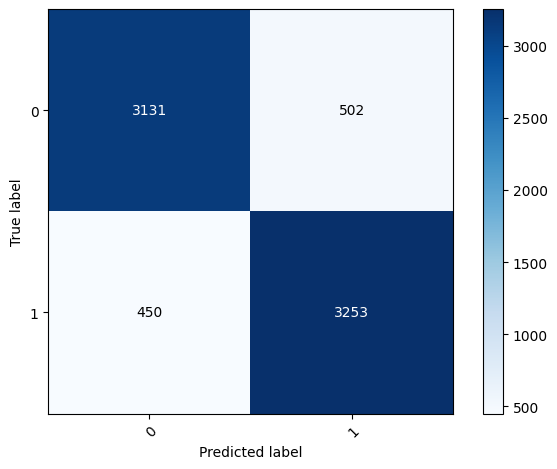

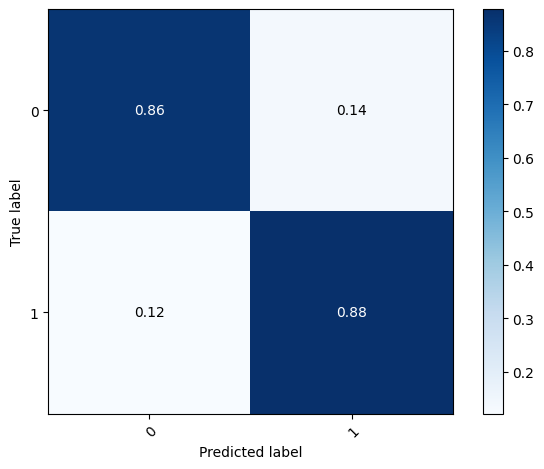

In [58]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, predict_nb, classes=class_names)
# plt.savefig('cm-nb.png')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, predict_nb, classes=class_names, normalize=True)
# plt.savefig('cm-nb-normalized.png')
plt.show()

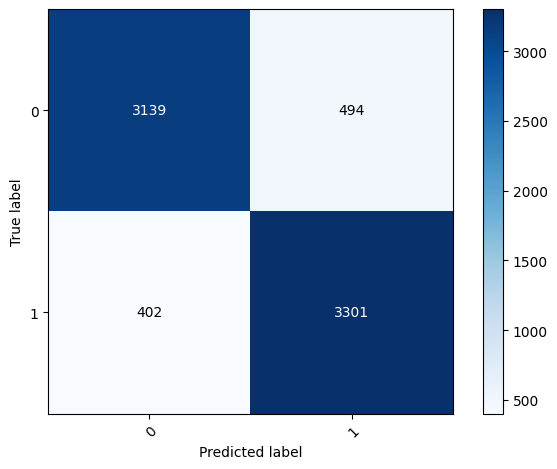

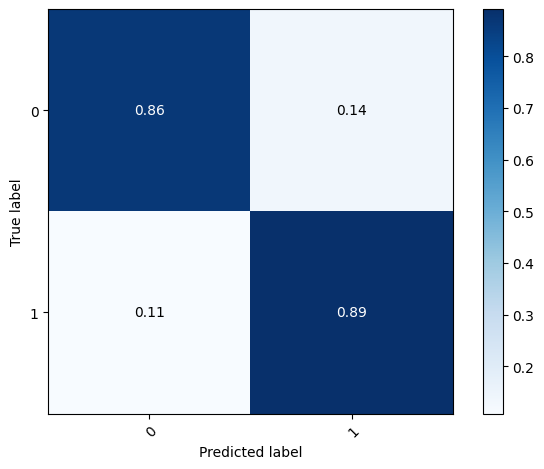

In [59]:

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, predict_svm, classes=class_names)
# plt.savefig('cm-svm.png')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, predict_svm, classes=class_names, normalize=True)
# plt.savefig('cm-svm-normalized.png')
plt.show()

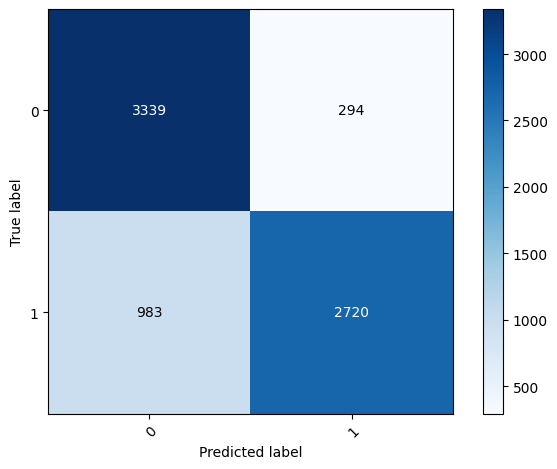

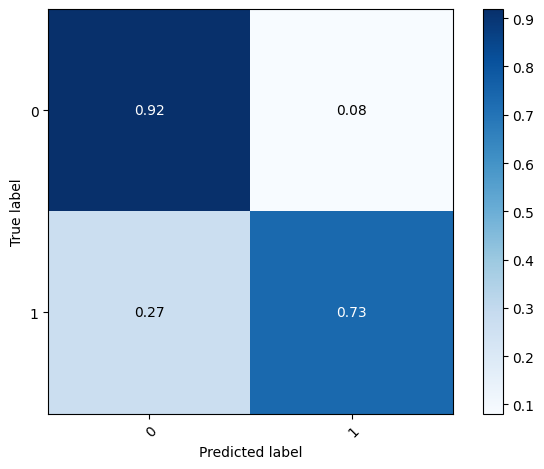

In [60]:

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, predict_sgd, classes=class_names)
# plt.savefig('cm-sgd.png')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, predict_sgd, classes=class_names, normalize=True)
# plt.savefig('cm-sgd-normalized.png')
plt.show()